## **Assignment 4**

# Question 1

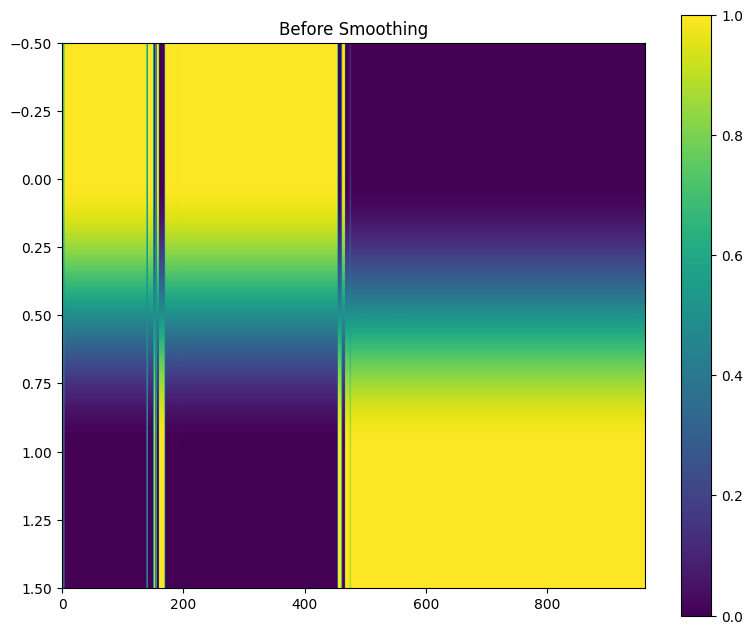

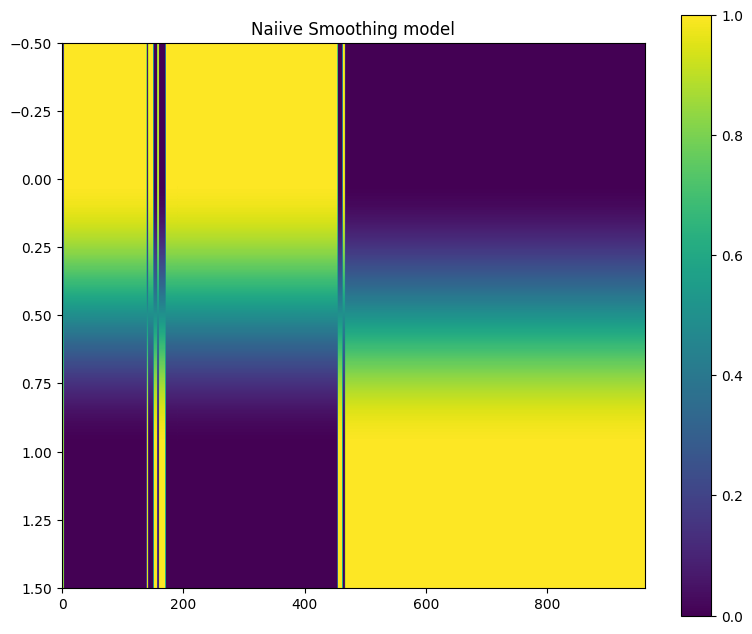

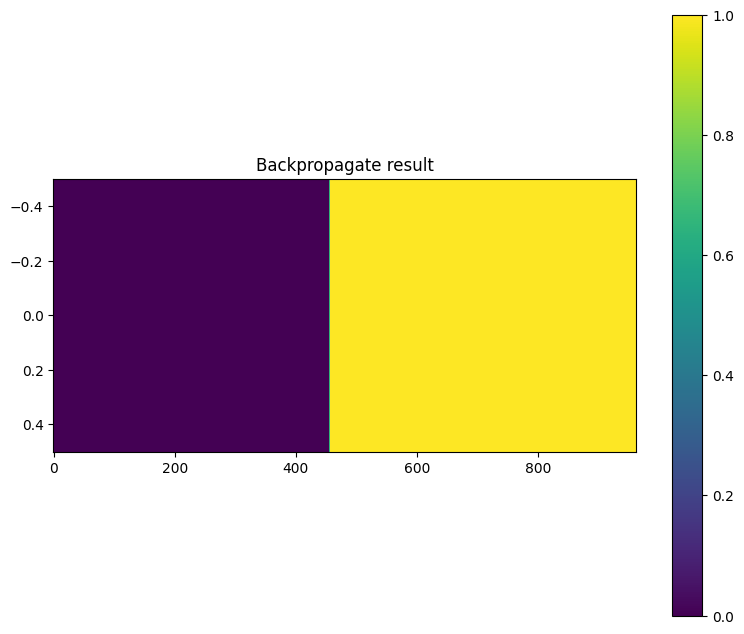

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import signal
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio
from scipy.stats import multivariate_normal


def multivariate_normal_pdf(x, mX, Sigma):
    n = len(x)
    mu1 = mX[:, 0]
    mu2 = mX[:, 1]
    cov1 = Sigma[:, :, 0]
    cov2 = Sigma[:, :, 1]
    det1 = np.linalg.det(cov1)
    inv1 = np.linalg.inv(cov1)
    det2 = np.linalg.det(cov2)
    inv2 = np.linalg.inv(cov2)

    coeff1 = 1.0 / (np.power((2 * np.pi), n / 2) * np.power(det1, 0.5))
    exponent1 = -0.5 * (x - mu1).T @ inv1 @ (x - mu1)
    p1 = coeff1 * np.exp(exponent1)

    coeff2 = 1.0 / (np.power((2 * np.pi), n / 2) * np.power(det2, 0.5))
    exponent2 = -0.5 * (x - mu2).T @ inv2 @ (x - mu2)
    p2 = coeff2 * np.exp(exponent2)

    return p1, p2


if __name__ == '__main__':
    audio, sr = librosa.load('/content/Piano_Clap.wav', sr=None)
    file1 = scipy.io.loadmat('/content/mfcc.mat')
    file2 = scipy.io.loadmat('/content/MuSigma.mat')
    X = file1["X"]
    mX = file2["mX"]
    Sigma = file2["Sigma"]

    P = np.zeros((2, 962))
    P_hat = np.zeros((2, 962))
    P_vet = np.zeros((2, 962))
    B = np.zeros((2, 962))

    for i in range(len(X[0])):
        x = X[:, i]
        pdf1, pdf2 = multivariate_normal_pdf(x, mX, Sigma)
        P[:, i] = pdf1, pdf2
        P[:, i] = P[:, i]/np.sum(P[:, i])


    P_bar = P

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(P_bar, aspect=450)
    plt.title("Before Smoothing")
    plt.colorbar()
    plt.show()

    T = np.array([[0.9,  0.1], [0, 1]])
    P_hat[:, 0] = P_bar[:, 0]

    for t in range(len(X[0])-1):
        b = np.argmax(P_bar[:, t])
        mul1 = T[b, :]
        P_hat[:, t + 1] = np.multiply(mul1, P_bar[:, t + 1])
        P_hat[:, t + 1] = P_hat[:, t + 1] / np.sum(P_hat[:, t + 1])

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(P_hat, aspect=450)
    plt.title("Naiive Smoothing model")
    plt.colorbar()
    plt.show()

    P_vet[:, 0] = P_bar[:, 0]
    for t in range(len(X[0])-1):
        mul01 = T[:, 0]
        mul2 = P_vet[:, t]
        mul11 = T[:, 1]
        temp0 = mul01 * mul2
        temp1 = mul11 * mul2
        b0 = np.argmax(temp0)
        b1 = np.argmax(temp1)
        B[0, t + 1] = b0
        B[1, t + 1] = b1

        P_vet[0, t + 1] = T[b0, 0] * P_vet[b0, t] * P_bar[0, t + 1]
        P_vet[1, t + 1] = T[b1, 1] * P_vet[b1, t] * P_bar[1, t + 1]

        help_p = T[b0, 0] * P_vet[b0, t]
        help_2 = help_p * P_bar[0, t + 1]

        P_vet[:, t+1] = P_vet[:, t+1]/np.sum(P_vet[:, t+1])

    # B = B[:, 1:961]
    s = np.zeros((1, 962))
    s[0, 961] = np.argmax(P_vet[:, 961])

    for t in range(961, 0, -1):
        row = int(s[0, t])
        s[0, t-1] = B[row, t-1]

    plt.figure(figsize=(9.4, 7.8))
    plt.imshow(s, aspect=450)
    plt.title("Backpropagate result")
    plt.colorbar()
    plt.show()


# Question 2

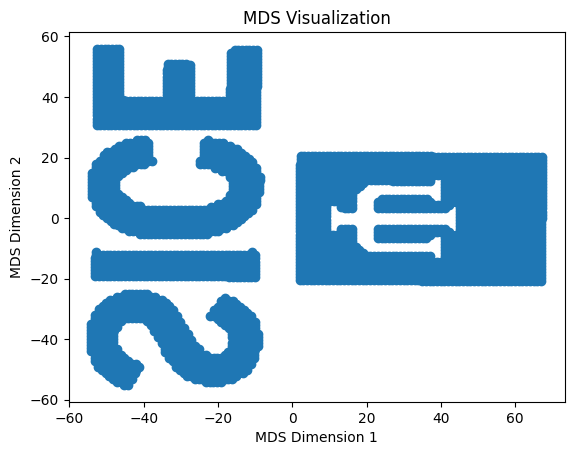

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

if __name__ == '__main__':
    file = scipy.io.loadmat('/content/MDS_pdist.mat')
    L = file["L"]

    column_means = np.mean(L, axis=0)
    L = L - column_means

    row_means = np.mean(L, axis=1)
    L = L - row_means.reshape(-1, 1)

    L = L / (-2)

    eigenvalues, eigenvectors = np.linalg.eig(L)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    mds_result = np.real(np.sqrt(np.diag(eigenvalues[:2])) @ eigenvectors[:, :2].T)

    x = mds_result[0, :]
    y = mds_result[1, :]

    plt.scatter(x, y)
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.title('MDS Visualization')
    plt.show()


# Question 3

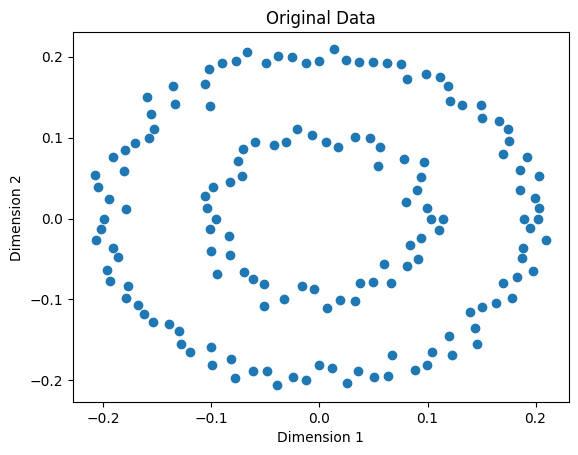

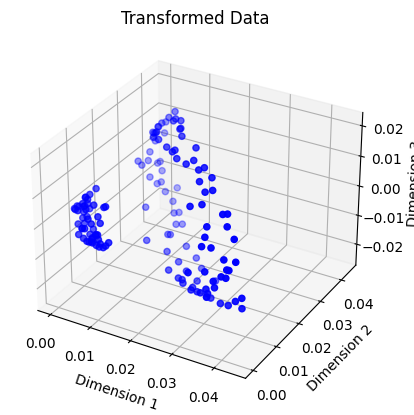

break


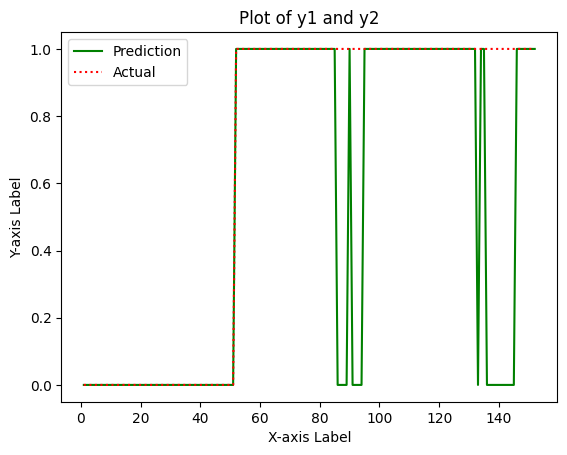

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io


def logistic_function(x):
    return 1 / (1 + np.exp(-x))


def logistic_function_derivative(x):
    return logistic_function(x) * (1 - logistic_function(x))


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    y = sigmoid(x)
    return y * (1 - y)


def W_init(rows, col):
    input_dim = rows
    output_dim = col

    std_dev = np.sqrt(2 / (input_dim + output_dim))
    W = np.random.randn(input_dim, output_dim) * std_dev

    return W


if __name__ == '__main__':
    file = scipy.io.loadmat('/content/concentric.mat')
    X = file["X"]
    labels = np.zeros((1, 152))
    labels[0, 51:] = 1

    x = X[0, :]
    y = X[1, :]

    plt.scatter(x, y)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Original Data')
    plt.show()

    Z = np.zeros((3, 152))
    Z[0, :] = np.power(X[0, :], 2)
    Z[1, :] = np.power(X[1, :], 2)
    Z[2, :] = X[0, :] * X[1, :]

    x = Z[0, :]
    y = Z[1, :]
    z = Z[2, :]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o', label='Data Points')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title('Transformed Data')
    plt.show()

    l_rate = 0.1
    tol = 1e-5
    epochs = 5000

    # weights = np.random.randn(3, 1)
    # weights = weights - weights.mean()
    weights = W_init(3, 1)
    biases = np.random.randn(1)

    for i in range(epochs):
        # Forward pass
        out = np.dot(weights.T, Z) + biases
        out_activated = sigmoid(out)

        loss = labels - out_activated
        error1 = loss * sigmoid_prime(out)

        if np.abs(np.mean(loss)) < tol:
            print("break")
            break

        weights += l_rate * np.dot(out_activated, error1.T)
        temp = np.sum(error1, axis=1, keepdims=True)
        biases += l_rate * temp[0, 0]

    test = np.dot(weights.T, Z) + biases
    test_activated = logistic_function(test)

    test_activated1 = test_activated.copy()

    for i in range(len(test_activated1[0])):
        if test_activated1[0, i] > 0.7:
            test_activated1[0, i] = 1
        else:
            test_activated1[0, i] = 0

    x_axis = np.arange(1, 153)

    fig, ax = plt.subplots()

    # ax.plot(x_axis, test_activated[0, :], 'b', label='Predicted')
    ax.plot(x_axis, test_activated1[0, :], 'g', label='Prediction')
    ax.plot(x_axis, labels[0, :], 'r', label='Actual', linestyle='dotted')

    ax.set_xlabel('X-axis Label')
    ax.set_ylabel('Y-axis Label')
    ax.set_title('Plot of y1 and y2')
    ax.legend()

    plt.show()

# Question 4

<ipython-input-11-4e5152305223>:78: RuntimeWarning: invalid value encountered in true_divide
  PC_X[0, :] = PC_X[0, :] / np.sum(PC_X[0, :])


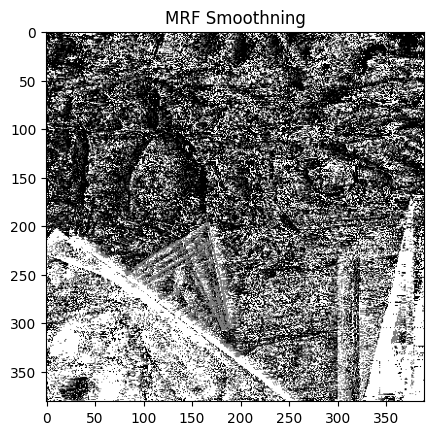

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt


def normal_pdf(x, mu, sigma):
    pdf = 1 / (sigma * math.sqrt(2 * math.pi)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    return pdf


def fun(Cij, Ckl):
    a = 10
    if Cij == Ckl:
        return 1
    else:
        return np.exp(-1 * (a ** 2))


if __name__ == "__main__":
    X = np.loadtxt('/content/vector.txt')
    X1 = X.reshape(-1, 1)

    k = 4
    P = np.array(np.ones(k) / k)

    groups = np.split(X[:148588], k)
    means = [group.mean() for group in groups]
    mu = np.array(means)

    sigma = np.ones(k)

    tol = 1e-6
    max_iter = 40
    log_likelihoods = []

    C_map = np.zeros((381, 390, max_iter+1))

    for iteration in range(max_iter):
        # E-step: compute responsibilities
        U_t = np.zeros((k, len(X)))
        for i in range(k):
            U_t[i] = normal_pdf(X, mu[i], sigma[i])
        U = np.transpose(U_t)
        P_diag = diagonal_matrix = np.diag(np.squeeze(P))
        U = U_log = np.matmul(U, P_diag)
        for j in range(len(X)):
            U[j] /= np.sum(U[j])

        # M-step: update parameters
        U_sum = np.sum(U, axis=0)
        P = U_sum / len(X)
        for k1 in range(k):
            mu[k1] = np.sum(U[:, k1] * X) / U_sum[k1]
            sigma[k1] = np.sqrt(np.sum(U[:, k1] * (X - mu[k1]) ** 2) / U_sum[k1])

        max_indexes = np.argmax(U, axis=1)
        C_map[:, :, iteration] = D_map = max_indexes.reshape(381, 390)

        PC_X = np.zeros((1, 4))

        ## MRF Smoothning
        for i in range(1, C_map.shape[0] - 1):  # 1 380
            for j in range(1, C_map.shape[1] - 1):  # 1, 389
                # Update pixel value using Gibbs sampling
                Cij = D_map[i, j]
                neighbors = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1),  # Top, bottom, left, right neighbors
                             (i - 1, j - 1), (i - 1, j + 1), (i + 1, j - 1), (i + 1, j + 1)]  # Diagonal neighbors

                for cluster in range(k):  # k = 4 number of clusters
                    PCX = normal_pdf(D_map[i, j], mu[cluster], sigma[cluster])

                    for neighbor in neighbors:
                        Ckl = D_map[neighbor]
                        PCX = PCX * fun(Cij, Ckl)

                    PC_X[0, cluster] = PCX

                PC_X[0, :] = PC_X[0, :] / np.sum(PC_X[0, :])
                C_map[i, j, iteration+1] = np.argmax(PC_X, axis=1)

        differ = C_map[:, :, iteration+1] - C_map[:, :, iteration]
        differ = np.square(differ)
        differ = np.sum(differ)

        if differ < tol:
            break

    matrix = C_map[:, :, iteration]
    matrix = matrix.flatten()

    zero_indices = np.where(matrix == 0)
    first_indices = np.where(matrix == 1)
    second_indices = np.where(matrix == 2)
    third_indices = np.where(matrix == 3)

    matrix_new = np.zeros(148590)
    matrix_new[zero_indices] = mu[0]
    matrix_new[first_indices] = mu[1]
    matrix_new[second_indices] = mu[2]
    matrix_new[third_indices] = mu[3]

    matrix_new= matrix_new.reshape(381, 390)
    plt.imshow(matrix_new, cmap='gray')
    plt.title("MRF Smoothning")
    plt.show()
